In [1]:
from prelim import do_prelim_on_single_feature
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi
import numpy as np
from matplotlib import pyplot as plt
import itertools
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from shapely.geometry import Polygon
from scipy import spatial
import alphashape
import requests

In [3]:
uri = "localhost:27017"
client = MongoClient(uri, server_api=ServerApi('1'))

client.admin.command('ping')

{'ok': 1.0}

In [4]:
db = client.test
historical_evolution_data = db.historicalEvolutionData
problem_instances = db.probleminstances
db_prelim_information = db.prelimInformation

In [5]:
experiment_id = "31-07-800"

transformed_projection_matrix_values = {
    "totalPassengerCount":[-0.8562,0.0328],
    "passengerRatio":[-0.6016,0.8155],
    "avgPassengerRouteLength":[-0.2747,-0.1704],
    "stdDevRailCarriageCapacity":[-0.4052,-0.2437],
    "totalCongestion":[0.6493,0.4862],
    "blockedPassengerRatio":[-0.5144,0.3437]
}

x_plot_lim = [-6, 5]
y_plot_lim = [-4, 5]

likely_border = [
[4.58424326144973,-1.97576002302582],
[4.22522988821809,2.98504102558966],
[2.29754949320531,4.27308813962706],
[-2.31533974869783,4.44968812717911],
[-4.04487975923197,3.40951045662756],
[-5.31868489813371,2.61948850727522],
[-4.95967152490207,-2.34131254134025],
[-3.03199112988929,-3.62935965537766],
[1.58089811201385,-3.80595964292971],
[3.31043812254799,-2.76578197237816],
[4.58424326144973,-1.97576002302582]
]

generator_colors = {
    "SimpleGenerator" : "orange",
    "RealisticGenerator" : "blue",
    "LocalSearchController" : "green"
}

sorted_feature_names = sorted(transformed_projection_matrix_values.keys())
transformed_projection_matrix = []
for i in range(0, len(sorted_feature_names)):
    transformed_projection_matrix.append(transformed_projection_matrix_values[sorted_feature_names[i]])

projection_matrix = np.array(transformed_projection_matrix).transpose()

In [6]:
def get_instances_and_coordinates():
    prelim_information = db_prelim_information.find({"experimentId" : experiment_id})
    instances = problem_instances.find({"experimentId" : experiment_id})
    instance_feature_vectors = list(map(lambda x: (x, convert_instance_to_feature_vector(x, prelim_information[0])), instances))
    return list(map(lambda x: (x[0], convert_feature_vector_to_coordinates(x[1])), instance_feature_vectors))

def convert_instance_to_feature_vector(instance, prelim_data):
    feature_vector = {}
    for feature in prelim_data["prelimDataOfFeatures"].keys():
        feature_vector[feature] = do_prelim_on_single_feature(instance["featureDescription"][feature], prelim_data["prelimDataOfFeatures"][feature])
    return feature_vector

def convert_feature_vector_to_coordinates(feature_vector):
    sorted_features= sorted(feature_vector.keys())
    vector_array = []
    for i in range(0, len(sorted_features)):
        vector_array.append(feature_vector[sorted_features[i]])
    vector = np.array(vector_array)
    return np.matmul(projection_matrix, vector)

def visualize_instance_space(instance_coordinate_pairs, border_coords = [], original_instances_more_transparent = False,targets = []):
        instance_coordinate_pairs.sort(key = lambda x: x[0]["featureDescription"]["source"])
        grouped_instances_by_source = itertools.groupby(instance_coordinate_pairs, key= lambda x: x[0]["featureDescription"]["source"])
        for key, group in grouped_instances_by_source:
            alpha = 1.0
            if (original_instances_more_transparent and (key == "SimpleGenerator" or key == "RealisticGenerator")):
                alpha = 0.3
            group_list = list(group)
            x_coords = [pair[1][0] for pair in group_list]
            y_coords = [pair[1][1] for pair in group_list]
            plt.scatter(x_coords, y_coords, label=key, color=generator_colors[key], alpha = alpha, s = 1.3)

        if (len(border_coords) > 0):
            xs, ys = zip(*border_coords)
            plt.plot(xs, ys, color='red')

        if (len(targets) > 0):
            xs, ys = zip(*targets)
            plt.scatter(xs, ys, color='black', marker = "s",s = 2)
    
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),ncol=3)
        ax = plt.gca()
        ax.set_axisbelow(True)
        plt.grid()
        plt.title("Instance Space By Source")
        plt.xlim(x_plot_lim)
        plt.xticks(np.arange(min(x_plot_lim), max(x_plot_lim), 1.0))
        plt.ylim(y_plot_lim)
        plt.yticks(np.arange(min(y_plot_lim), max(y_plot_lim), 1.0))
        plt.show()

def create_border_coordinates(border_values):
    prelim_information = db_prelim_information.find({"experimentId" : experiment_id})
    prelim_data = prelim_information[0]
    for feature in prelim_data["prelimDataOfFeatures"].keys():
        for border_point in border_values:
            border_point[feature] = do_prelim_on_single_feature(border_point[feature], prelim_data["prelimDataOfFeatures"][feature])
    return list(map(lambda x: convert_feature_vector_to_coordinates(x), border_values))

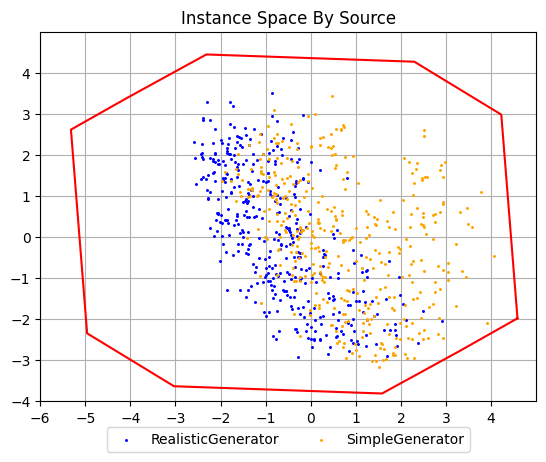

In [7]:
problem_instances.delete_many({"experimentId" : experiment_id, "source" : "LocalSearchController"})
instances_and_coordinates = get_instances_and_coordinates()
visualize_instance_space(instances_and_coordinates, border_coords = likely_border)

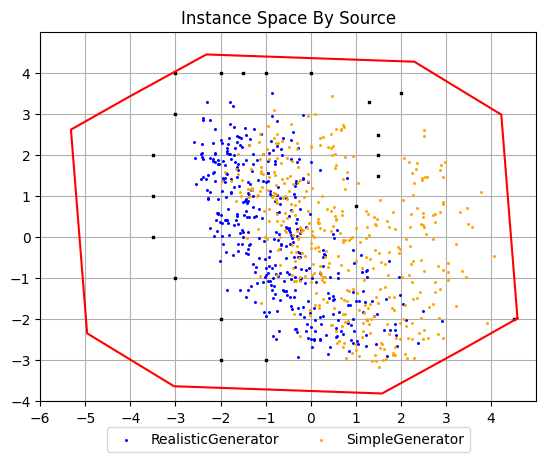

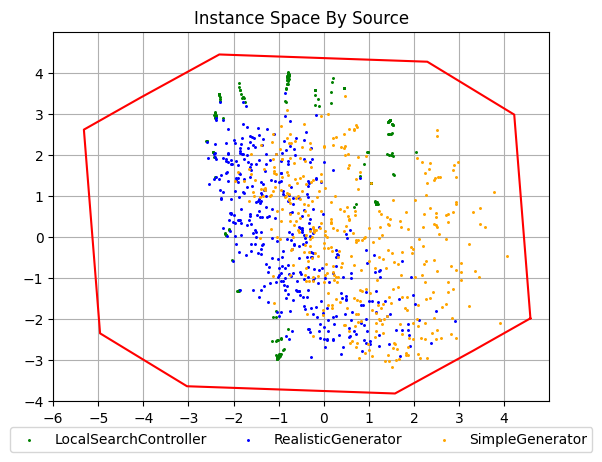

In [10]:
def midpoint(p1, p2):
    return [(p1[0]+p2[0])/2, (p1[1]+p2[1])/2]

def create_target_points_across_border():
    target_points = []
    for i in range (1, len(likely_border)):
        first_point = likely_border[i-1]
        second_point = likely_border[i]
        mid_point = midpoint(first_point, second_point)
    
        target_points.append(first_point)
        target_points.append(second_point)
        target_points.append(mid_point)
    return target_points

def post_local_search_generation(target_x, target_y, mutation_name, iterations, local_search_rounds):
    url = 'http://localhost:8080/localsearch/generate'
    data = {
        "experimentId": "31-07-800",
        "transposedProjectionMatrix" : [
            [-0.8562,0.0328],
            [-0.6016,0.8155],
            [-0.2747,-0.1704],
            [-0.4052,-0.2437],
            [0.6493,0.4862],
            [-0.5144,0.3437]
        ],
        "featureNames" : ["totalPassengerCount", "passengerRatio","avgPassengerRouteLength","stdDevRailCarriageCapacity", "totalCongestion", "blockedPassengerRatio"],
        "targetX" : target_x,
        "targetY" : target_y,
        "mutationName" : mutation_name,
        "iterations" : iterations,
        "localSearchRounds" : local_search_rounds
    }

    requests.post(url, json=data)

def local_search(target_points, mutation_type, iterations, local_search_rounds):
    for point in target_points:
        post_local_search_generation(point[0], point[1], mutation_type, iterations, local_search_rounds)   

target_points = [[1.5,1.5],[1.5,2],[1.5,2.5],[1,0.75],[1.3,3.3], [2, 3.5], [0, 4], [-1,4],[-1.5,4],[-2,4],[-3,4],[-3,3],[-3.5,2],[-3.5,1],
                 [-3.5,0],[-3, -1],[-2,-2],[-2,-3],[-1,-3]]


  

instances_and_coordinates = get_instances_and_coordinates()
visualize_instance_space(instances_and_coordinates, border_coords = likely_border, targets = target_points)

local_search(target_points, "AddPassengerMutation", 4, 5)  

instances_and_coordinates = get_instances_and_coordinates()
visualize_instance_space(instances_and_coordinates, border_coords = likely_border)

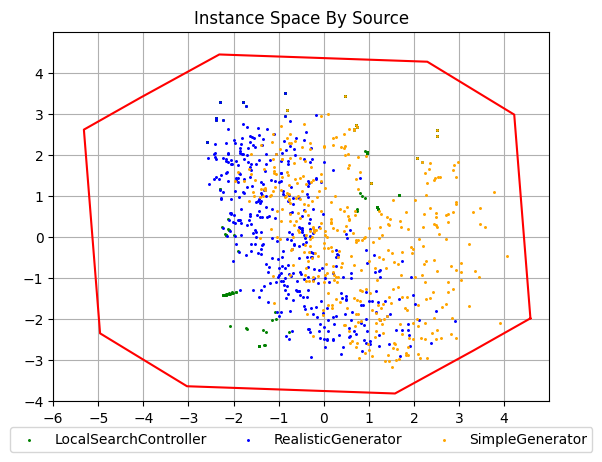

In [16]:
problem_instances.delete_many({"experimentId" : experiment_id, "source" : "LocalSearchController"})
local_search(target_points, "IncreaseAvgRouteLengthMutation", 4, 5)  
instances_and_coordinates = get_instances_and_coordinates()
visualize_instance_space(instances_and_coordinates, border_coords = likely_border)

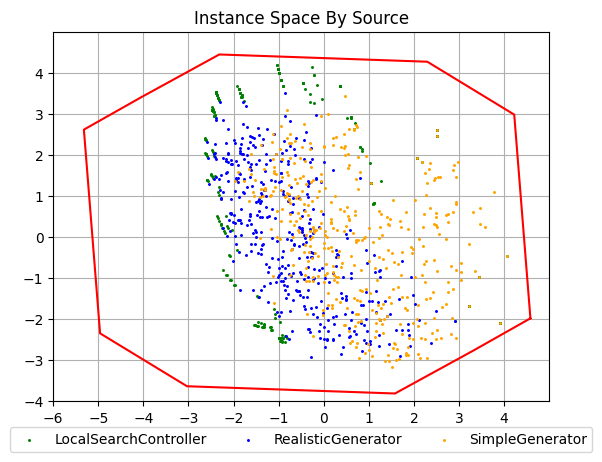

In [18]:
problem_instances.delete_many({"experimentId" : experiment_id, "source" : "LocalSearchController"})
local_search(target_points, "AddBlockedPassengerMutation", 4, 5)  
instances_and_coordinates = get_instances_and_coordinates()
visualize_instance_space(instances_and_coordinates, border_coords = likely_border)

In [7]:
def plot_feature_combination(instances, feature_1, feature_2, colored_by_generator = False):
    if colored_by_generator:
        instances.sort(key = lambda x: x["source"])
        grouped_instances_by_source = itertools.groupby(instances, key= lambda x: x["source"])
        for key, group in grouped_instances_by_source:
            grouped_instances = list(group)
            x_coords = [instance["featureDescription"][feature_1] for instance in grouped_instances]
            y_coords = [instance["featureDescription"][feature_2] for instance in grouped_instances]
            plt.scatter(x_coords, y_coords, label=key, color=generator_colors[key])
    else:
        x_coords = [instance["featureDescription"][feature_1] for instance in instances]
        y_coords = [instance["featureDescription"][feature_2] for instance in instances]
        plt.scatter(x_coords, y_coords)

    plt.xlabel(feature_1)
    plt.ylabel(feature_2)
    
    plt.grid()
    plt.show()

instances = list(problem_instances.find({"experimentId" : experiment_id}))
feature_names = ["totalPassengerCount", "passengerRatio","avgPassengerRouteLength","stdDevRailCarriageCapacity", "totalCongestion", "blockedPassengerRatio"]
feature_combinations = list(itertools.combinations(feature_names, 2))

for combination in feature_combinations:
    #plot_feature_combination(instances, combination[0], combination[1], colored_by_generator = True)

SyntaxError: incomplete input (3936471650.py, line 26)